In [174]:
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import seaborn as sns
from typing import Callable
from matplotlib.lines import Line2D

pd.set_option("display.max.columns", 50)
pd.set_option("precision", 1)
# os.chdir(os.path.dirname(os.path.realpath(__file__)))
DATADIR = os.path.join("..", "data")
LOGDIR = os.path.join("..", "logs")

strategies = [
    "naive_random",
    "greedy_random",
    "greedy_eigenvector",
    "greedy_diameter"
]

all_strategies = [
    "naive_random",
    "greedy_random",
    "greedy_eigenvector",
    "greedy_diameter",
    "max_diameter",
    "balanced_diameter_1",
    "balanced_diameter_3",
    "balanced_diameter_5",
    "balanced_diameter_7",
    "balanced_diameter_9"
]


In [218]:
results = [pd.read_csv(os.path.join(DATADIR, "simul_results", f"{strategy}.csv")) for strategy in all_strategies]
results = pd.concat(results, ignore_index=True)
results = results.groupby(["strategy", "group"]).mean().drop(columns="sim")
results.columns = [c.replace("'", "").replace("(", "").replace(")", "").replace(",", "").replace(" ", "_") for c in results.columns]
results = (
    results
    .loc[:, [col for col in results.columns if "0.25" in col or "1.0" in col]]
    .unstack(0)
    .loc[:, lambda df: df.columns.get_level_values(1).isin(strategies)]
)
results.columns = results.columns.to_flat_index()
results.columns = [f"{x[0]}_{x[1]}" for x in results.columns]
results = results.reset_index().rename({"group": "name"}, axis=1).set_index("name")
results

,caught_proportion_0.25_greedy_diameter,caught_proportion_0.25_greedy_eigenvector,caught_proportion_0.25_greedy_random,caught_proportion_0.25_naive_random,caught_proportion_1.0_greedy_diameter,caught_proportion_1.0_greedy_eigenvector,caught_proportion_1.0_greedy_random,caught_proportion_1.0_naive_random,eigen_proportion_0.25_greedy_diameter,eigen_proportion_0.25_greedy_eigenvector,eigen_proportion_0.25_greedy_random,eigen_proportion_0.25_naive_random,eigen_proportion_1.0_greedy_diameter,eigen_proportion_1.0_greedy_eigenvector,eigen_proportion_1.0_greedy_random,eigen_proportion_1.0_naive_random
name,,,,,,,,,,,,,,,,
17Nov_greece,28.1,28.8,30.2,36.0,105.1,107.0,107.0,116.2,23.9,23.8,25.9,29.4,105.1,107.0,107.0,116.2
911_hijackers,99.0,104.5,98.6,119.2,415.7,413.5,412.2,439.1,67.3,94.9,75.4,90.7,415.7,413.5,412.2,439.1
Islamic_state_group,54.9,53.2,54.2,59.0,226.5,223.1,231.6,229.1,32.7,31.1,31.0,33.8,226.5,223.1,231.6,229.1
al_qaeda,172.7,177.2,176.2,224.7,817.2,816.6,833.6,859.7,274.3,304.7,278.6,364.8,817.2,816.6,833.6,859.7
caviar,139.7,137.6,142.9,223.6,854.0,848.2,838.9,875.5,62.8,52.1,58.4,129.4,854.0,848.2,838.9,875.5
cocaine_acero,51.4,47.3,45.5,55.7,216.1,203.7,200.1,211.9,33.7,29.3,27.2,36.1,216.1,203.7,200.1,211.9
cocaine_jake,65.4,68.4,67.2,84.7,339.6,336.0,334.3,341.9,37.9,41.9,40.5,54.6,339.6,336.0,334.3,341.9
cocaine_juanes,80.3,82.1,80.1,102.4,377.1,389.8,385.9,408.8,61.6,58.0,57.7,78.4,377.1,389.8,385.9,408.8
cocaine_mambo,46.8,48.5,47.0,64.4,222.3,229.8,225.8,242.6,32.2,33.6,32.2,50.4,222.3,229.8,225.8,242.6


In [219]:
#Parse tables and reduce the simul data a bit and engineer a few features of the summaries

summaries = pd.read_pickle(os.path.join(DATADIR, "processed_data", "network_summaries.pkl"))
summaries["density"] = summaries.degree_mean / (summaries.nodes - 1)
summaries["eig_cent_range"] = summaries.eig_cent_max - summaries.eig_cent_min
summaries["eig_cent_ratio"] = summaries.eig_cent_max / summaries.eig_cent_min
summaries["eig_cent_logratio"] = np.log(summaries["eig_cent_ratio"])
summaries["degree_range"] = summaries.degree_max - summaries.degree_min
summaries["degree_ratio"] = summaries.degree_max / summaries.degree_min
summaries = summaries.drop(index=6)
summaries = summaries.assign(network_type = [2, 1, 2, 1, 0, 2, 0, 0, 2, 0, 2, 2, 0, 0, 2, 2, 2])
network_type_labels = {0: "drugs", 1: "terrorism", 2: "gang"}
color_dict = {0: "tab:blue", 1: "tab:orange", 2: "tab:red"}
network_colors = summaries["network_type"].apply(lambda x: color_dict[x]).tolist()
legend_handles = [Line2D([], [], marker='.', markersize=20, color=color, linestyle='None') for color in color_dict.values()]

#Merge together
summaries = pd.merge(summaries, results, on=["name"]).set_index("name")


#Helper histogram explore function
def explore_hist(
    col:str, 
    filter_func:Callable = None, 
    df:pd.DataFrame = summaries, 
    ascending:bool = False
    ):
    df[col].plot(kind='hist', subplots=True, title=col)
    if filter_func == None:
        filter_func = lambda x: x[col] > 0
    print(df[filter_func].sort_values(by=col, ascending=ascending)[col])

def add_jitter(jitter):
    return np.random.normal(0, jitter)

def labelled_scatter(
    xlabel, 
    ylabel, 
    data, 
    title="", 
    ax = None, 
    yjitter = 0,
    xjitter = 0,
    colors=network_colors, 
    legend_handles=legend_handles, 
    legend_labels=list(network_type_labels.values())
):
    if ax == None:
        fig, ax = plt.subplots(figsize=(14, 14))

    ax.scatter(xlabel, ylabel, data=data, c=colors)
    for i in data.index:
        ax.text(x=data.loc[i, xlabel] + add_jitter(xjitter), y=data.loc[i, ylabel] + add_jitter(yjitter), s=i)
    for spine in ["top", "right"]:
        ax.spines[spine].set_visible(False)

    ax.legend(legend_handles, legend_labels)
    ax.set_title(title)
    
    if ax == None:
        return fig

In [220]:
summaries.describe()

,nodes,edges,degree_mean,degree_max,degree_min,diameter,triangles,average_clustering,eig_cent_mean,eig_cent_max,eig_cent_min,density,eig_cent_range,eig_cent_ratio,eig_cent_logratio,degree_range,degree_ratio,network_type,caught_proportion_0.25_greedy_diameter,caught_proportion_0.25_greedy_eigenvector,caught_proportion_0.25_greedy_random,caught_proportion_0.25_naive_random,caught_proportion_1.0_greedy_diameter,caught_proportion_1.0_greedy_eigenvector,caught_proportion_1.0_greedy_random,caught_proportion_1.0_naive_random,eigen_proportion_0.25_greedy_diameter,eigen_proportion_0.25_greedy_eigenvector,eigen_proportion_0.25_greedy_random,eigen_proportion_0.25_naive_random,eigen_proportion_1.0_greedy_diameter,eigen_proportion_1.0_greedy_eigenvector,eigen_proportion_1.0_greedy_random,eigen_proportion_1.0_naive_random
count,17.0,17.0,17.0,17.0,17.0,17.0,17.0,17.0,1.7e+01,17.0,1.7e+01,1.7e+01,1.7e+01,17.0,17.0,17.0,17.0,17.0,17.0,17.0,17.0,17.0,17.0,17.0,17.0,17.0,17.0,17.0,17.0,17.0,17.0,17.0,17.0,17.0
mean,63.2,244.1,6.0,25.9,1.2,5.2,45535.5,0.5,1.1e-01,0.4,1.6e-02,1.1e-01,4.0e-01,6821.4,4.4,24.6,21.8,1.2,80.4,81.1,80.7,113.7,383.1,382.8,382.3,409.0,61.5,63.3,61.2,92.3,383.1,382.8,382.3,409.0
std,42.0,387.3,5.3,19.5,0.8,1.8,156296.7,0.2,4.4e-02,0.1,1.8e-02,7.2e-02,9.9e-02,27663.7,2.3,19.0,15.1,1.0,40.6,41.7,41.7,65.3,245.9,245.2,245.9,249.9,57.0,64.8,58.2,78.4,245.9,245.2,245.9,249.9
min,18.0,27.0,2.2,9.0,1.0,2.0,3.0,0.1,3.6e-02,0.2,2.8e-06,3.4e-02,2.3e-01,7.2,2.0,8.0,9.0,0.0,28.1,28.8,30.2,36.0,105.1,107.0,107.0,116.2,23.9,23.8,25.9,29.4,105.1,107.0,107.0,116.2
25%,33.0,50.0,3.5,15.0,1.0,4.0,35.0,0.4,7.6e-02,0.3,1.5e-03,7.1e-02,3.2e-01,18.6,2.9,14.0,13.0,0.0,54.9,53.2,54.2,67.7,226.5,229.8,226.9,242.6,33.7,33.6,32.2,50.4,226.5,229.8,226.9,242.6
50%,51.0,93.0,3.7,17.0,1.0,5.0,57.0,0.4,1.1e-01,0.4,7.2e-03,9.0e-02,4.2e-01,53.2,4.0,16.0,17.0,2.0,60.9,61.5,62.4,84.7,273.5,274.3,272.9,280.2,49.8,47.2,49.9,67.8,273.5,274.3,272.9,280.2
75%,78.0,312.0,5.0,25.0,1.0,6.0,4321.0,0.6,1.4e-01,0.5,2.7e-02,1.2e-01,4.6e-01,223.7,5.4,23.0,20.0,2.0,99.0,103.2,98.6,139.2,415.7,413.5,412.2,439.1,62.8,58.0,58.4,91.4,415.7,413.5,412.2,439.1
max,151.0,1619.0,21.4,75.0,4.0,10.0,646230.0,0.8,2.0e-01,0.6,6.3e-02,3.0e-01,5.7e-01,114171.3,11.6,71.0,60.0,2.0,172.7,177.2,176.2,252.2,905.0,906.8,906.5,929.5,274.3,304.7,278.6,364.8,905.0,906.8,906.5,929.5


In [221]:
summaries

,nodes,edges,degree_mean,degree_max,degree_min,diameter,triangles,average_clustering,eig_cent_mean,eig_cent_max,eig_cent_min,density,eig_cent_range,eig_cent_ratio,eig_cent_logratio,degree_range,degree_ratio,network_type,caught_proportion_0.25_greedy_diameter,caught_proportion_0.25_greedy_eigenvector,caught_proportion_0.25_greedy_random,caught_proportion_0.25_naive_random,caught_proportion_1.0_greedy_diameter,caught_proportion_1.0_greedy_eigenvector,caught_proportion_1.0_greedy_random,caught_proportion_1.0_naive_random,eigen_proportion_0.25_greedy_diameter,eigen_proportion_0.25_greedy_eigenvector,eigen_proportion_0.25_greedy_random,eigen_proportion_0.25_naive_random,eigen_proportion_1.0_greedy_diameter,eigen_proportion_1.0_greedy_eigenvector,eigen_proportion_1.0_greedy_random,eigen_proportion_1.0_naive_random
name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
togo,33,47,2.8,19,1,4,14,0.5,1.4e-01,0.6,3.2e-02,8.9e-02,0.6,18.6,2.9,18,19.0,2,60.9,61.1,62.4,74.6,262.5,274.3,272.9,277.2,32.4,31.4,32.0,47.7,262.5,274.3,272.9,277.2
mali_terrorists,36,67,3.7,11,1,7,43,0.4,1.2e-01,0.4,7.2e-03,1.1e-01,0.4,53.2,4.0,10,11.0,1,55.2,52.7,55.2,67.7,273.5,267.7,265.3,279.4,50.3,47.2,50.1,63.4,273.5,267.7,265.3,279.4
london_gang,54,315,11.7,25,2,4,4321,0.6,1.1e-01,0.2,8.8e-03,2.2e-01,0.2,28.4,3.3,23,12.5,2,51.9,53.7,52.3,81.9,189.4,190.6,194.3,228.7,41.2,42.7,41.5,67.8,189.4,190.6,194.3,228.7
Islamic_state_group,25,27,2.2,9,1,4,3,0.1,1.6e-01,0.5,4.4e-02,9.0e-02,0.5,12.4,2.5,8,9.0,1,54.9,53.2,54.2,59.0,226.5,223.1,231.6,229.1,32.7,31.1,31.0,33.8,226.5,223.1,231.6,229.1
heroin_natarjan,38,87,4.6,20,1,4,46,0.4,1.4e-01,0.4,3.3e-02,1.2e-01,0.4,12.9,2.6,19,20.0,0,58.3,58.2,58.6,81.4,240.7,235.2,239.7,272.4,42.7,42.4,43.3,65.3,240.7,235.2,239.7,272.4
italian_gangs,65,113,3.5,21,1,6,57,0.4,9.3e-02,0.4,6.9e-03,5.4e-02,0.4,63.6,4.2,20,21.0,2,105.9,103.2,105.4,139.2,509.1,501.0,495.0,532.2,57.2,49.8,56.7,91.4,509.1,501.0,495.0,532.2
cocaine_mambo,31,58,3.7,15,1,4,35,0.4,1.4e-01,0.5,2.0e-02,1.2e-01,0.4,23.6,3.2,14,15.0,0,46.8,48.5,47.0,64.4,222.3,229.8,225.8,242.6,32.2,33.6,32.2,50.4,222.3,229.8,225.8,242.6
cocaine_jake,38,50,2.6,12,1,4,15,0.1,1.2e-01,0.5,2.7e-02,7.1e-02,0.4,16.6,2.8,11,12.0,0,65.4,68.4,67.2,84.7,339.6,336.0,334.3,341.9,37.9,41.9,40.5,54.6,339.6,336.0,334.3,341.9
17Nov_greece,18,46,5.1,17,1,2,940,0.7,2.0e-01,0.4,6.3e-02,3.0e-01,0.4,7.2,2.0,16,17.0,2,28.1,28.8,30.2,36.0,105.1,107.0,107.0,116.2,23.9,23.8,25.9,29.4,105.1,107.0,107.0,116.2


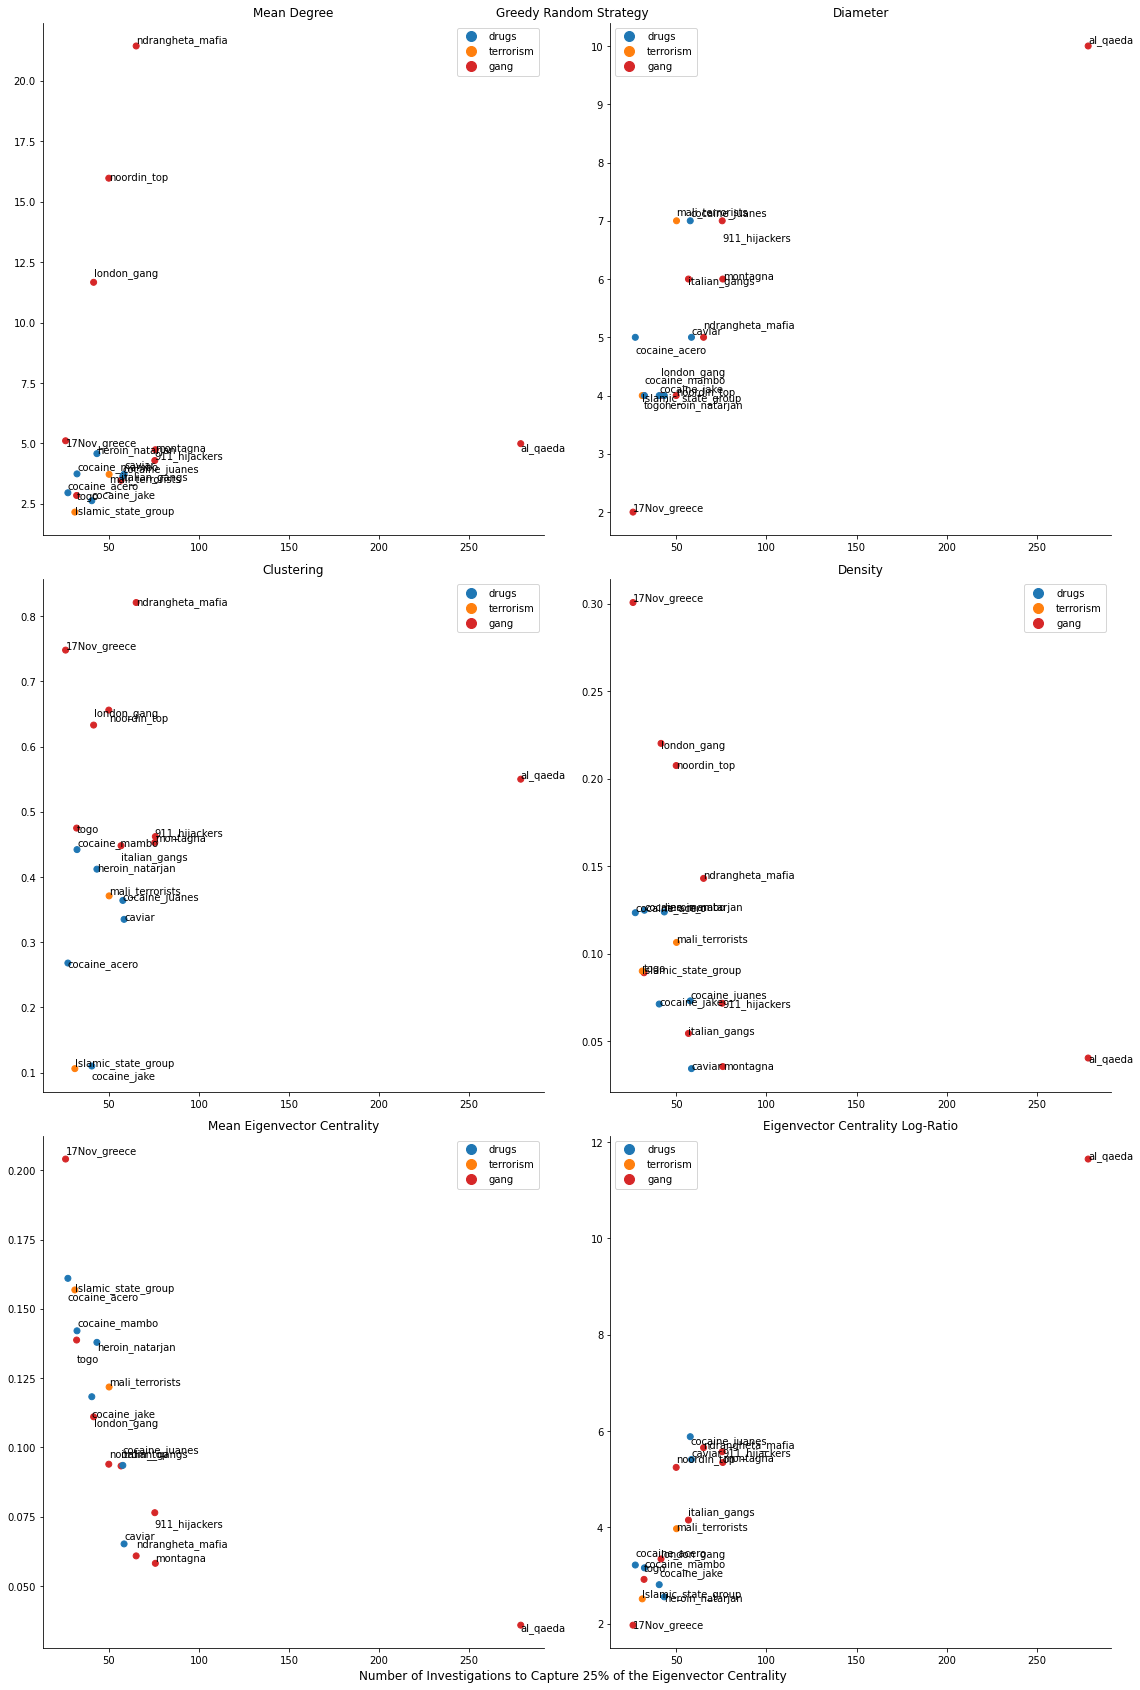

In [118]:
xlabel = "eigen_proportion_0.25_greedy_random"
ylabel = "eig_cent_logratio"

ylabels = ["degree_mean", "diameter", "average_clustering", "density", "eig_cent_mean", "eig_cent_logratio"]
yjitters = [0.2, 0.2, 0.01, 0.001, 0.004, 0.1]
titles = ["Mean Degree", "Diameter", "Clustering", "Density", "Mean Eigenvector Centrality", "Eigenvector Centrality Log-Ratio"]

def strategy_results_summary(xlabel, ylabels, titles, yjitters, figtitle="", figxlabel=""):
    fig, axs = plt.subplots(3, 2, figsize=(16, 24), tight_layout=True)
    for ax, ylabel, title, yjitter in zip(axs.ravel(), ylabels, titles, yjitters):
        labelled_scatter(xlabel, ylabel, summaries, yjitter = yjitter, title=title, ax=ax)
    fig.suptitle(figtitle)
    fig.supxlabel(figxlabel)
    return fig

eigen_greedy_fig = strategy_results_summary(
    "eigen_proportion_0.25_greedy_random", 
    ylabels, 
    titles, 
    yjitters, 
    figtitle="Greedy Random Strategy",
    figxlabel="Number of Investigations to Capture 25% of the Eigenvector Centrality"
)


Based on Measures of density: we see that the most dense are ndrangheta_mafia, 17Nov_greece, noordin and london. Al Qaeda is really just middle of the pack

name
17Nov_greece    0.3
london_gang     0.2
noordin_top     0.2
Name: density, dtype: float64


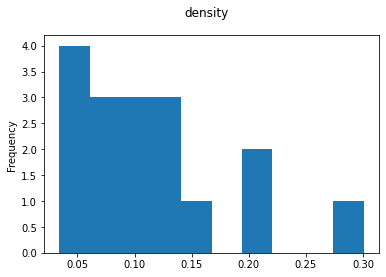

In [44]:
explore_hist("density", lambda x: x["density"] > 0.2)

name
ndrangheta_mafia    0.8
17Nov_greece        0.7
noordin_top         0.7
london_gang         0.6
al_qaeda            0.6
Name: average_clustering, dtype: float64


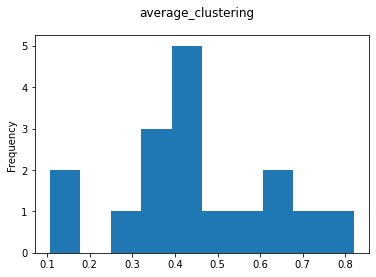

In [45]:
explore_hist("average_clustering", lambda x: x["average_clustering"] > 0.5)

Exploring the eigenvalues. Nov Greece is a bit higher than everyone else in terms of mean. Al Qaeda is bottom of the barrel for mean eigenvector centrality. It also has the lowest minimum eigenvector centrality and an astronomical ratio between max and min. This is likely its success considering especially how we are calculating success. A number of networks are also obviously in an upper echeclon of ratios. 

name
17Nov_greece           2.0e-01
cocaine_acero          1.6e-01
Islamic_state_group    1.6e-01
cocaine_mambo          1.4e-01
togo                   1.4e-01
heroin_natarjan        1.4e-01
mali_terrorists        1.2e-01
cocaine_jake           1.2e-01
london_gang            1.1e-01
noordin_top            9.4e-02
cocaine_juanes         9.4e-02
italian_gangs          9.3e-02
911_hijackers          7.6e-02
caviar                 6.5e-02
ndrangheta_mafia       6.1e-02
montagna               5.8e-02
al_qaeda               3.6e-02
Name: eig_cent_mean, dtype: float64


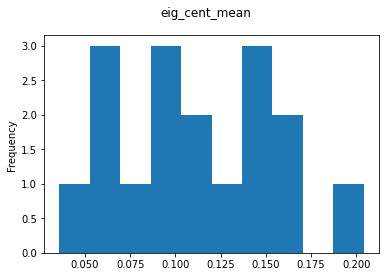

In [46]:
explore_hist("eig_cent_mean")

name
al_qaeda            11.6
cocaine_juanes       5.9
ndrangheta_mafia     5.7
911_hijackers        5.6
caviar               5.4
montagna             5.3
noordin_top          5.2
Name: eig_cent_logratio, dtype: float64


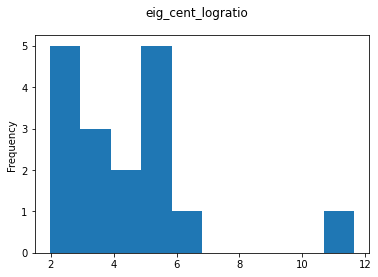

In [47]:
explore_hist("eig_cent_logratio", lambda x: x["eig_cent_logratio"] > 5)

(array([5., 3., 2., 5., 1., 0., 0., 0., 0., 1.]),
 array([ 1.97150536,  2.93890031,  3.90629527,  4.87369023,  5.84108519,
         6.80848014,  7.7758751 ,  8.74327006,  9.71066501, 10.67805997,
        11.64545493]),
 <BarContainer object of 10 artists>)

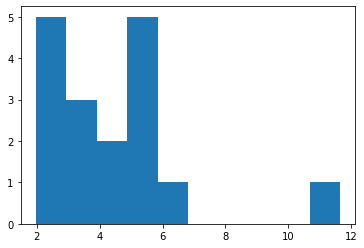

In [48]:
#Quick and dirty log transform
plt.hist(np.log(np.array(summaries["eig_cent_ratio"].to_list())))

name
togo                   0.6
Islamic_state_group    0.5
caviar                 0.5
cocaine_acero          0.5
cocaine_mambo          0.5
cocaine_juanes         0.5
cocaine_jake           0.5
17Nov_greece           0.4
italian_gangs          0.4
911_hijackers          0.4
heroin_natarjan        0.4
mali_terrorists        0.4
al_qaeda               0.3
montagna               0.3
noordin_top            0.3
london_gang            0.2
ndrangheta_mafia       0.2
Name: eig_cent_max, dtype: float64


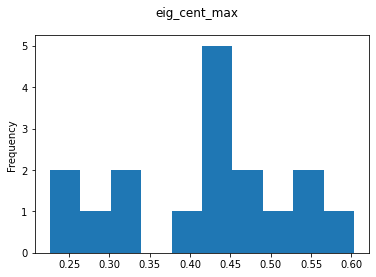

In [49]:
explore_hist("eig_cent_max")

name
london_gang         8.8e-03
mali_terrorists     7.2e-03
italian_gangs       6.9e-03
caviar              2.4e-03
911_hijackers       1.7e-03
montagna            1.5e-03
noordin_top         1.4e-03
cocaine_juanes      1.3e-03
ndrangheta_mafia    7.9e-04
al_qaeda            2.8e-06
Name: eig_cent_min, dtype: float64


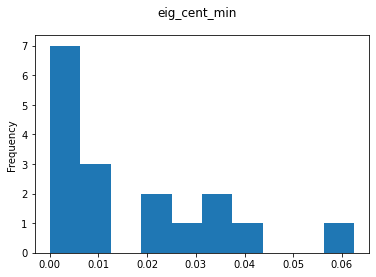

In [50]:
explore_hist("eig_cent_min", lambda x: x["eig_cent_min"] < 0.01)

Al qaeda is really just middle of the pack more or less in mean degree. Ndrangheta mafia is a claer high along wiht noordin and london gang. Note that although al qaeda has astronomical eigenvector centrality ratio it does not have a really high degree ratio. 

name
ndrangheta_mafia    21.4
noordin_top         16.0
london_gang         11.7
17Nov_greece         5.1
al_qaeda             5.0
Name: degree_mean, dtype: float64


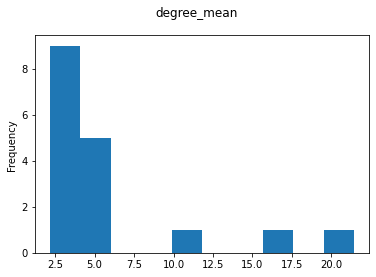

In [51]:
explore_hist("degree_mean", lambda x: x["degree_mean"] > 4.9)

name
ndrangheta_mafia       75
caviar                 60
noordin_top            55
montagna               40
london_gang            25
italian_gangs          21
heroin_natarjan        20
togo                   19
al_qaeda               17
17Nov_greece           17
cocaine_juanes         16
911_hijackers          15
cocaine_mambo          15
cocaine_acero          13
cocaine_jake           12
mali_terrorists        11
Islamic_state_group     9
Name: degree_max, dtype: int64


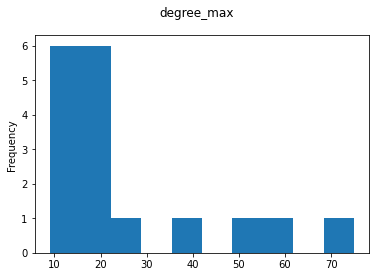

In [52]:
explore_hist("degree_max")

name
caviar         60.0
noordin_top    55.0
montagna       40.0
Name: degree_ratio, dtype: float64


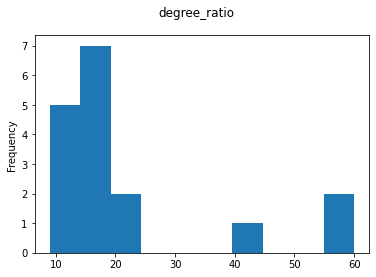

In [53]:
explore_hist("degree_ratio", lambda x: x["degree_ratio"] > 25)

name
ndrangheta_mafia    71
caviar              59
noordin_top         54
montagna            39
Name: degree_range, dtype: int64


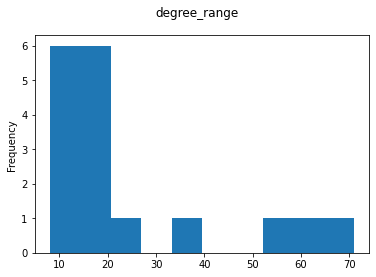

In [54]:
explore_hist("degree_range", lambda x: x["degree_range"] > 30)

Clear importance here of high diameter of al_qaeda I would say

name
al_qaeda           10
mali_terrorists     7
911_hijackers       7
cocaine_juanes      7
italian_gangs       6
montagna            6
Name: diameter, dtype: int64


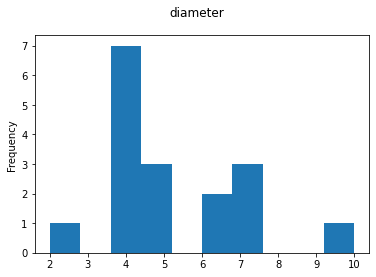

In [55]:
explore_hist("diameter", lambda x: x["diameter"] >= 6)

name
al_qaeda               278.6
montagna                75.7
911_hijackers           75.4
ndrangheta_mafia        65.1
caviar                  58.4
cocaine_juanes          57.7
italian_gangs           56.7
mali_terrorists         50.1
noordin_top             49.9
heroin_natarjan         43.3
london_gang             41.5
cocaine_jake            40.5
cocaine_mambo           32.2
togo                    32.0
Islamic_state_group     31.0
cocaine_acero           27.2
17Nov_greece            25.9
Name: eigen_proportion_0.25_greedy_random, dtype: float64


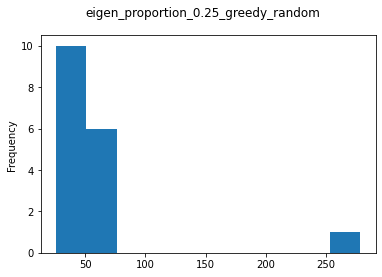

In [56]:
explore_hist("eigen_proportion_0.25_greedy_random")